## Evaluate Classifiers

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, load_from_disk, concatenate_datasets
from sklearn.metrics import accuracy_score
import random
from tqdm import tqdm
import numpy as np
import torch
import os

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Random Seed for Reproducibility

In [2]:
# Set a seed for random module
random.seed(42)

# Set a seed for numpy module
np.random.seed(42)

# Set a seed for torch module
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define Parameters

In [3]:
SAMPLING = "random" # "random", "stratified", "clustered", "shared_domain"
SUFFIX = "_extended" #"", "_holdout", "_extended"
SPLITS = ['train', 'test', 'holdout', 'extended', 'holdout_url', 'extended_url']
MAX_CONTENT_LENGTH = 384 # 496, 192
OVERLAP = 64
FEATURES = "url_and_content" # "url", "content", "url_and_content"

In [4]:
TOPIC = "energie" # "cannabis", "kinder", "energie"
MODEL = "deepset/gbert-large" #gbert-base, gbert-large, deepset/gelectra-base, deepset/gelectra-large

## Helpers

In [5]:
from tabulate import tabulate
from IPython.display import display, HTML

def display_metrics_table(eval_results):
    """
    Display evaluation metrics as an HTML table.

    Parameters:
    eval_results (dict): A dictionary where keys are split names (e.g., 'train', 'test')
                         and values are dictionaries containing 'metrics' and 'count'.
    """
    # Prepare headers for the table
    headers = ["Split", "Accuracy", "Precision", "Recall", "F1 Score", "Count"]

    # Prepare rows
    rows = []
    for split, data in eval_results.items():
        metrics = data.get("metrics", {})
        count = data.get("count", 0)
        row = [
            split,
            metrics.get('accuracy', 0.0),
            metrics.get('precision', 0.0),
            metrics.get('recall', 0.0),
            metrics.get('f1', 0.0),
            count
        ]
        rows.append(row)

    # Generate the HTML table
    table_html = tabulate(rows, headers=headers, tablefmt="html", floatfmt=".3f")

    # Display the HTML table
    display(HTML(table_html))


## Evaluate Models

In [6]:
def calc_metrics(labels, preds):
    """
    Calculates the accuracy, precision, recall, and F1 score for the given labels and predictions and returns them in a dictionary.
    """
    
    metrics = {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average='binary'),
        'recall': recall_score(labels, preds, average='binary'),
        'f1': f1_score(labels, preds, average='binary'),
    }

    return metrics

## Load Predictions

In [7]:
dataset = load_from_disk(f"../../data_ccu/tmp/processed_dataset_{TOPIC}_buffed_chunkified_{SAMPLING}{SUFFIX}_{MAX_CONTENT_LENGTH}_with_urls_{MODEL.split('/')[1]}_{FEATURES}_with_predictions")

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'chunk_id', 'url_path', 'preds', 'probas'],
        num_rows: 4227
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'chunk_id', 'url_path', 'preds', 'probas'],
        num_rows: 579
    })
    holdout: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'chunk_id', 'url_path', 'preds', 'probas'],
        num_rows: 39782
    })
    extended: Datas

In [9]:
dataset["test"][0]

{'_id': '64a0946e749484eec856370d',
 'batch_id': 16,
 'domain': 'campact.de',
 'view_url': 'aktion.campact.de/datenschutz/schufa-bonify/teilnehmen?utm_medium=email&utm_source=campact_mailing&utm_campaign=20230622-as-hv-schufa-3-aktiv-und-neu-v3-nein-button&utm_content=variation-a&utm_term=link1',
 'lang': 'de',
 'text': 'Schufa: Finger weg von meinem Konto Schufa: Finger weg von meinem Konto Bereits 238.861 Unterzeichner*innen. Wer eine Wohnung mieten oder einen Kredit aufnehmen will, ist oft abhängig von der Bewertung der Schufa. Jetzt will Deutschlands größte Auskunftei Dich dazu verführen, auch Deine Kontodaten preiszugeben. Ob Gehalt oder Kontostand – all das könnte die Schufa sehen. Wir finden: Unsere Konten gehen die Schufa nichts an. Unterzeichne jetzt unseren Appell! Unsere Forderung Appell-Empfängerin Tanja Birkholz, Vorstandsvorsitzende der Schufa Holding AG Bewertungen durch die Schufa sind für Menschen immer wieder entscheidend dafür, ob sie eine Wohnung, einen Kredit oder 

## Precision-Recall Curves

In [10]:
# Initialize dictionaries
preds_and_labels_per_page = {}
labels_per_page = []
preds_per_page = []
probas_per_page = []

# Iterate over the splits
for split in SPLITS:
            
    # Group dataset examples by URL, with a fallback to domain
    grouped_dataset = {}
    for example in tqdm(dataset[split]):
        url = example.get("view_url") or example.get("domain")
        example_filtered = {k: example[k] for k in ["text", "domain", "preds", "label", "category", "annotation_type", "lang", "probas"]}
        grouped_dataset.setdefault(url, []).append(example_filtered)
        
    # Extract labels
    labels = []
    for url, chunks in grouped_dataset.items():
        label = max([chunk["label"] for chunk in chunks])
        labels.append(label)
        
    # Merge chunk level predictions
    predictions = []
    for url, chunks in grouped_dataset.items():
        preds = [chunk["preds"] for chunk in chunks]
        predictions.append(max(preds))
        
    # Merge chunk level probabilities
    probas = []
    for url, chunks in grouped_dataset.items():
        probas.append(max([chunk["probas"] for chunk in chunks]))

    # Store the predictions and labels for the current split
    preds_and_labels_per_page[split] = {"preds": predictions, "labels": labels, "probas": probas, "count": len(labels)}
    labels_per_page.extend(labels)
    preds_per_page.extend(predictions)
    probas_per_page.extend(probas)

    # Use the trained model to make predictions on the test set
    metrics = calc_metrics(labels, predictions)
    preds_and_labels_per_page[split]["metrics"] = metrics
    print(f"Metrics for {MODEL} on {TOPIC}: {metrics}")
    

100%|██████████| 4227/4227 [00:00<00:00, 6442.63it/s]


Metrics for deepset/gbert-large on energie: {'accuracy': 0.9975369458128078, 'precision': 1.0, 'recall': 0.995049504950495, 'f1': 0.9975186104218362}


100%|██████████| 579/579 [00:00<00:00, 6267.17it/s]


Metrics for deepset/gbert-large on energie: {'accuracy': 0.9782608695652174, 'precision': 0.9583333333333334, 'recall': 1.0, 'f1': 0.9787234042553191}


100%|██████████| 39782/39782 [00:06<00:00, 6508.57it/s]
/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics for deepset/gbert-large on energie: {'accuracy': 0.9358789625360231, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


100%|██████████| 229661/229661 [00:36<00:00, 6370.29it/s]


Metrics for deepset/gbert-large on energie: {'accuracy': 0.9803592814371257, 'precision': 0.030204962243797196, 'recall': 0.9032258064516129, 'f1': 0.05845511482254697}


100%|██████████| 1245/1245 [00:00<00:00, 5474.44it/s]


Metrics for deepset/gbert-large on energie: {'accuracy': 0.9397590361445783, 'precision': 0.28421052631578947, 'recall': 0.7941176470588235, 'f1': 0.4186046511627907}


100%|██████████| 41908/41908 [00:07<00:00, 5727.15it/s]


Metrics for deepset/gbert-large on energie: {'accuracy': 0.9554261716140117, 'precision': 0.124765478424015, 'recall': 0.9925373134328358, 'f1': 0.22166666666666668}


In [11]:
display_metrics_table(preds_and_labels_per_page)

Split,Accuracy,Precision,Recall,F1 Score,Count
train,0.998,1.000,0.995,0.998,406
test,0.978,0.958,1.000,0.979,46
holdout,0.936,0.000,0.000,0.000,4164
extended,0.980,0.030,0.903,0.058,45925
holdout_url,0.940,0.284,0.794,0.419,1245
extended_url,0.955,0.125,0.993,0.222,41908


In [12]:
preds_and_labels_per_page_merged = preds_and_labels_per_page.copy()

#### Create unbalanced test set ####
preds_and_labels_per_page_merged["holdout"]["labels"] = preds_and_labels_per_page["holdout_url"]["labels"] + preds_and_labels_per_page["holdout"]["labels"] + preds_and_labels_per_page["test"]["labels"]

preds_and_labels_per_page_merged["holdout"]["preds"] = preds_and_labels_per_page["holdout_url"]["preds"] + preds_and_labels_per_page["holdout"]["preds"] + preds_and_labels_per_page["test"]["preds"]

preds_and_labels_per_page_merged["holdout"]["probas"] = preds_and_labels_per_page["holdout_url"]["probas"] + preds_and_labels_per_page["holdout"]["probas"] + preds_and_labels_per_page["test"]["probas"]

#### Create extended test set ####
preds_and_labels_per_page_merged["extended"]["labels"] = preds_and_labels_per_page["extended_url"]["labels"] + preds_and_labels_per_page["extended"]["labels"]

preds_and_labels_per_page_merged["extended"]["preds"] = preds_and_labels_per_page["extended_url"]["preds"] + preds_and_labels_per_page["extended"]["preds"]

preds_and_labels_per_page_merged["extended"]["probas"] = preds_and_labels_per_page["extended_url"]["probas"] + preds_and_labels_per_page["extended"]["probas"]


#### Remove unnecessary splits ####
preds_and_labels_per_page_merged.pop("holdout_url")
preds_and_labels_per_page_merged.pop("extended_url")
preds_and_labels_per_page_merged.pop("train")
print(preds_and_labels_per_page_merged.keys())

dict_keys(['test', 'holdout', 'extended'])


In [13]:
labels_per_page = []
preds_per_page = []

# Iterate over the splits
for split in preds_and_labels_per_page_merged.keys():
    
    # Get the labels and predictions for the current split
    labels = preds_and_labels_per_page_merged[split]["labels"]
    preds = preds_and_labels_per_page_merged[split]["preds"]
    labels_per_page.extend(labels)
    preds_per_page.extend(preds)

    # Calculate the metrics for the current split
    metrics = calc_metrics(labels, preds)
    preds_and_labels_per_page_merged[split]["metrics"] = metrics
    preds_and_labels_per_page_merged[split]["count"] = len(labels)
    print(f"Metrics for {MODEL} on {TOPIC} for split {split}:\n {metrics}\n")

Metrics for deepset/gbert-large on energie for split test:
 {'accuracy': 0.9782608695652174, 'precision': 0.9583333333333334, 'recall': 1.0, 'f1': 0.9787234042553191}

Metrics for deepset/gbert-large on energie for split holdout:
 {'accuracy': 0.937121906507791, 'precision': 0.12953367875647667, 'recall': 0.8771929824561403, 'f1': 0.22573363431151242}

Metrics for deepset/gbert-large on energie for split extended:
 {'accuracy': 0.9684628784169959, 'precision': 0.09610983981693363, 'recall': 0.9832775919732442, 'f1': 0.17510422870756404}



In [14]:

# Concatenate the labels for all splits 
labels_per_page_merged = [
    label for split in preds_and_labels_per_page_merged.keys() if split != 'train' for label in preds_and_labels_per_page[split].get("labels", [])
]

# Concatenate the predictions for all splits
preds_per_page_merged = [
    prediction for split in preds_and_labels_per_page_merged.keys() if split != 'train' for prediction in preds_and_labels_per_page[split].get("preds", [])
]

# Concatenate the probabilities for all splits
probas_per_page_merged = [
    probas for split in preds_and_labels_per_page_merged.keys() if split != 'train' for probas in preds_and_labels_per_page[split].get("probas", [])
]

# Calculate the metrics for all splits
metrics = calc_metrics(labels_per_page_merged, preds_per_page_merged)
print(f"Metrics for {MODEL} on {TOPIC} for all splits:\n {metrics}\n")

Metrics for deepset/gbert-large on energie for all splits:
 {'accuracy': 0.9666359526003385, 'precision': 0.10579417699625253, 'recall': 0.9683377308707124, 'f1': 0.19074844074844075}



In [15]:
display_metrics_table(preds_and_labels_per_page_merged)

Split,Accuracy,Precision,Recall,F1 Score,Count
test,0.978,0.958,1.000,0.979,46
holdout,0.937,0.130,0.877,0.226,5455
extended,0.968,0.096,0.983,0.175,87833


In [16]:
len(labels_per_page_merged), len(preds_per_page_merged), len(probas_per_page_merged)

(93334, 93334, 93334)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

In [18]:
# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(labels_per_page_merged, probas_per_page_merged)

In [19]:
# Calculate AUC for the precision-recall curve
pr_auc = auc(recall, precision)
print(f'Precision-Recall AUC: {pr_auc:.2f}')

Precision-Recall AUC: 0.81


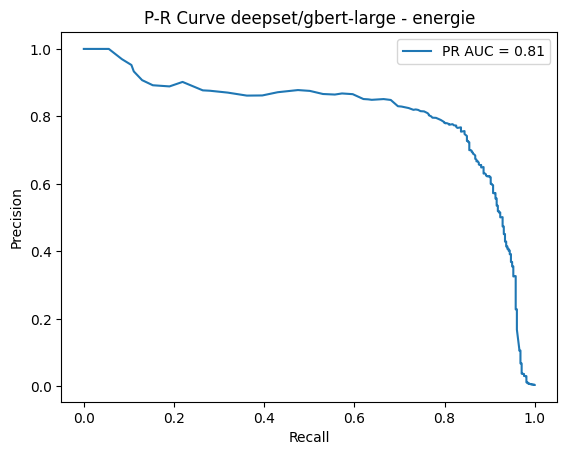

In [20]:
# Log the y_test and y_scores values
#print('y_test:', labels_per_page_merged)
#print('y_scores:', probas_per_page_merged)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'P-R Curve {MODEL} - {TOPIC}')
plt.legend(loc='best')

# Save the figure with dynamic filename
filename = f'precision_recall_curve_{MODEL.split("/")[1]}_{TOPIC}.png'.replace(' ', '_')
plt.savefig(filename, dpi=300)

plt.show()